In [8]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

import joblib
import torch


In [22]:
X, Y = make_moons(n_samples=1000, random_state=42, noise=0.1)

In [38]:
def train_test_plot(X_train, y_train, X_test, y_test, title1="Train", title2="Test"):
    plt.figure(figsize=(16, 7))

    ax = plt.subplot(121)
    plt.title(title1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    _ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

    plt.subplot(122, sharex=ax, sharey=ax)
    plt.title(title2)
    plt.xlabel("$x_1$")
    # Если классификатор предсказал вероятность принадлежности первому классу >= 0.5, считаем объект принадлежащим классу 1
    # в противном случае - 0
    _ = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y."""
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    margin_x1 = (X[:, 0].max() - X[:, 0].min()) * 0.1
    margin_x2 = (X[:, 1].max() - X[:, 1].min()) * 0.1

    x_min, x_max = X[:, 0].min() - margin_x1, X[:, 0].max() + margin_x1
    y_min, y_max = X[:, 1].min() - margin_x2, X[:, 1].max() + margin_x2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 501), np.linspace(y_min, y_max, 501))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="Set3", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)

    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def train_test_model_plot(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)

    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)


In [42]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)


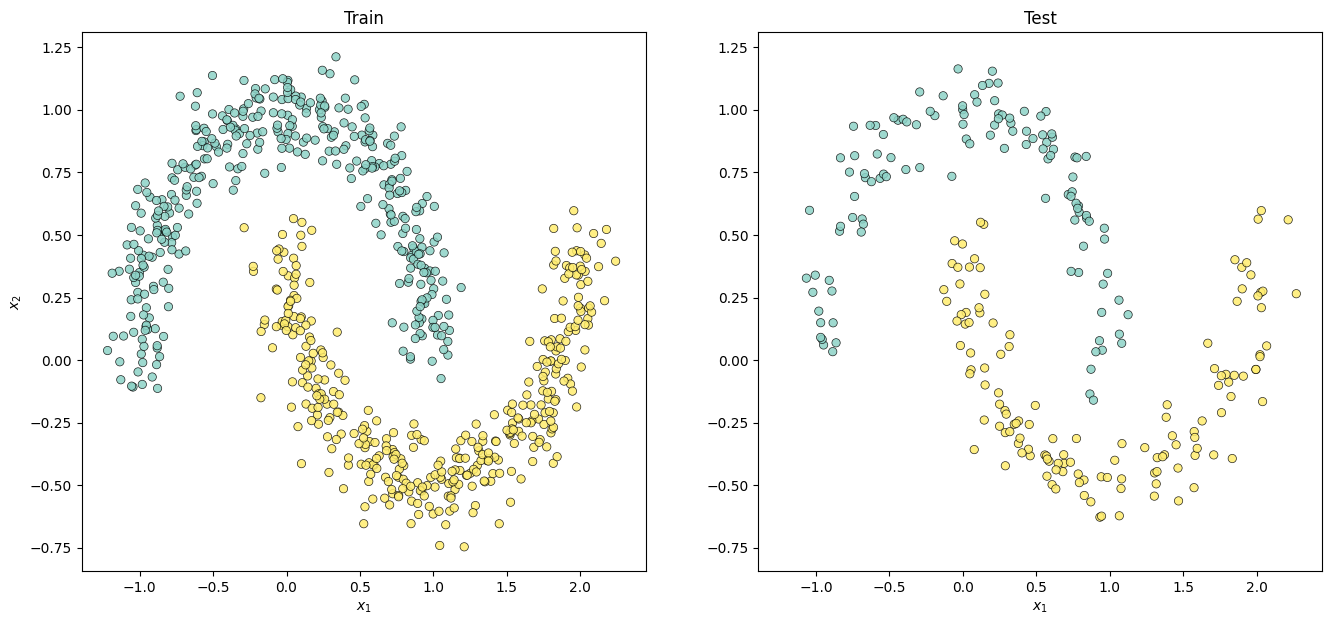

In [43]:
train_test_plot(X_train, y_train, X_test, y_test)

In [ ]:
class OurLinearNet(torch.nn.Module):
    def __init__(self, input_features, out_features, hidden_units):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_units)
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.fc3 = torch.nn.Linear(hidden_units, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [62]:
class OurNonLinearNet(torch.nn.Module):
	def __init__(self, input_features, out_features, hidden_units):
		super().__init__()
		self.fc1 = torch.nn.Linear(input_features, hidden_units)
		self.relu1 = torch.nn.ReLU()
		self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
		self.relu2 = torch.nn.ReLU()
		self.fc3 = torch.nn.Linear(hidden_units, out_features)


	def forward(self, x):
		x = self.relu1(self.fc1(x))
		x = self.relu2(self.fc2(x))
		x = self.fc3(x)
		return x


In [81]:
net1 = OurLinearNet(2, 1, 16)
net2 = OurNonLinearNet(2, 1, 50)

In [82]:
net2

OurNonLinearNet(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [83]:
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.SGD(net1.parameters(), lr=0.005)
optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.005)

In [74]:
def learn_binary_classification(model, optimizer, n_epochs):

    for epoch in range(n_epochs):

        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fun(y_logits, y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss:.5f}")

In [84]:
learn_binary_classification(net2, optimizer2, 30_000)

Epoch 0: loss = 0.67727
Epoch 100: loss = 0.64265
Epoch 200: loss = 0.60373
Epoch 300: loss = 0.55985
Epoch 400: loss = 0.51336
Epoch 500: loss = 0.46851
Epoch 600: loss = 0.42909
Epoch 700: loss = 0.39677
Epoch 800: loss = 0.37098
Epoch 900: loss = 0.35041
Epoch 1000: loss = 0.33378
Epoch 1100: loss = 0.32005
Epoch 1200: loss = 0.30844
Epoch 1300: loss = 0.29840
Epoch 1400: loss = 0.28955
Epoch 1500: loss = 0.28165
Epoch 1600: loss = 0.27454
Epoch 1700: loss = 0.26812
Epoch 1800: loss = 0.26230
Epoch 1900: loss = 0.25701
Epoch 2000: loss = 0.25217
Epoch 2100: loss = 0.24775
Epoch 2200: loss = 0.24369
Epoch 2300: loss = 0.23994
Epoch 2400: loss = 0.23648
Epoch 2500: loss = 0.23325
Epoch 2600: loss = 0.23023
Epoch 2700: loss = 0.22738
Epoch 2800: loss = 0.22469
Epoch 2900: loss = 0.22213
Epoch 3000: loss = 0.21967
Epoch 3100: loss = 0.21729
Epoch 3200: loss = 0.21498
Epoch 3300: loss = 0.21272
Epoch 3400: loss = 0.21051
Epoch 3500: loss = 0.20833
Epoch 3600: loss = 0.20621
Epoch 3700: l

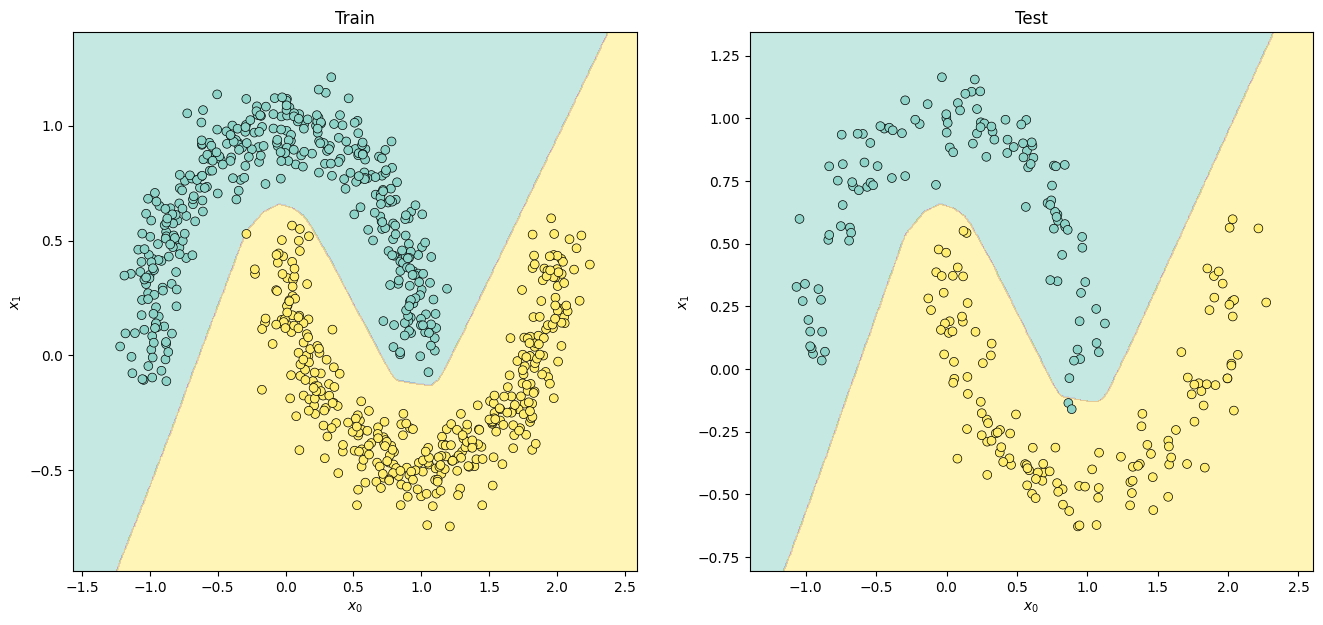

In [85]:
train_test_model_plot(net2, X_train, y_train, X_test, y_test)